In [1]:
!pip install category_encoders --quiet
# Update sklearn
!pip uninstall scikit-learn -y --quiet
!pip install -U scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 17.4 MB/s eta 0:00:00


In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import cross_validate
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [65]:
data = pd.read_csv('https://raw.githubusercontent.com/KhiemDangLe/Final-Project/main/DataFolder/5_preprocessed_data.csv')
df_location = pd.read_csv('https://raw.githubusercontent.com/KhiemDangLe/Final-Project/main/DataFolder/7_coordinates_by_street_name_1_5000.csv')
df_location2 = pd.read_csv('https://raw.githubusercontent.com/KhiemDangLe/Final-Project/main/DataFolder/8_coordinates_by_street_nam_5000_end.csv')

merged_df1 = pd.merge(data, df_location[['article_id', 'longitude', 'latitude']], on='article_id', how='inner')
merged_df2 = pd.merge(data, df_location2[['article_id', 'longitude', 'latitude']], on='article_id', how='inner')
merged_df = pd.concat([merged_df1, merged_df2], ignore_index=True)

y = merged_df['price'].copy()
X = merged_df.drop('price',axis=1).copy()

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5389 entries, 0 to 5388
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   article_id          5389 non-null   int64  
 1   category            5389 non-null   object 
 2   phone               5388 non-null   float64
 3   district            5389 non-null   object 
 4   date_posted         5389 non-null   object 
 5   area                5389 non-null   float64
 6   bedroom             4827 non-null   float64
 7   wc                  4426 non-null   float64
 8   direction           564 non-null    object 
 9   balcony_direction   233 non-null    object 
 10  total_room_LLm      2778 non-null   float64
 11  count_conveniences  5389 non-null   int64  
 12  alleyway_property   4695 non-null   float64
 13  under_mortgage      962 non-null    float64
 14  furnished           1388 non-null   float64
 15  has_lowerlevel      1376 non-null   float64
 16  has_ro

# **1. Tạo pipeline**

## **a) Linear regression**

In [67]:
# Những cột được chọn sau khi thực hiện bước Feature Selection
select_cols_for_lr = ['area', 'bedroom', 'wc', 'total_room_LLm', 'count_conveniences', 'alleyway_property', 'numbers_of_floors', 'longitude', 'latitude']

# Tạo class để lọc ra cột
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, subset):
        self.subset = subset

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.subset]

In [68]:
linear_regression_pipeline = Pipeline(steps=[
    ('column_selector', ColumnSelector(subset=select_cols_for_lr)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('linear_regression', LinearRegression())
])

In [69]:
linear_regression_pipeline.fit(X, y)
coefficients = linear_regression_pipeline.named_steps['linear_regression'].coef_

coef_dict_baseline = {}
for coef, feat in zip(coefficients, X.columns):
    coef_dict_baseline[feat] = coef

print("Coefficients:", coef_dict_baseline)

Coefficients: {'article_id': 3.817446019881465, 'category': 1.8499497778971943, 'phone': 3.0337133260351337, 'district': -0.25064922522952815, 'date_posted': -0.857208616225182, 'area': 0.8833177409556768, 'bedroom': 2.273005498979601, 'wc': 2.023779261880671, 'direction': -0.8693666915433332}


## **b) Lasso regression**

In [70]:
lasso_regression_pipeline = Pipeline(steps=[
    ('custom_selector', ColumnSelector(subset=select_cols_for_lr)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lasso_regression', Lasso(alpha=0.0012949258422052632))
])

In [71]:
lasso_regression_pipeline.fit(X, y)
coefficients = lasso_regression_pipeline.named_steps['lasso_regression'].coef_

coef_dict_baseline = {}
for coef, feat in zip(coefficients, X.columns):
    coef_dict_baseline[feat] = coef

print("Coefficients với StandardScaler:", coef_dict_baseline)

Coefficients với StandardScaler: {'article_id': 0.6014103734627175, 'category': 0.32048817067765223, 'phone': 0.5528246226043613, 'district': -0.028373881797733914, 'date_posted': -0.20575272632783975, 'area': 0.04039610627151446, 'bedroom': 0.31618024874493417, 'wc': 0.22164344558281732, 'direction': -0.08594314895875126}


## **c) Ridge regression**

In [72]:
ridge_regression_pipeline = Pipeline(steps=[
    ('custom_selector', ColumnSelector(subset=select_cols_for_lr)),
    ('imputer', SimpleImputer(strategy='mean')),
    # đồi với ridge thì phù hợp với MinMaxScaler hơn
    ('scaler',  MinMaxScaler()),
    ('ridge_regression', Ridge(alpha=5.000110381399524))
])

In [73]:
ridge_regression_pipeline.fit(X, y)
coefficients = ridge_regression_pipeline.named_steps['ridge_regression'].coef_

coef_dict_baseline = {}
for coef, feat in zip(coefficients, X.columns):
    coef_dict_baseline[feat] = coef

print("Coefficients với MinMaxScaler:", coef_dict_baseline)

Coefficients với MinMaxScaler: {'article_id': 3.667250765090656, 'category': 1.9048999230956893, 'phone': 2.9433443316403256, 'district': -0.17162432042065848, 'date_posted': -0.845040787660497, 'area': 0.6258092323155349, 'bedroom': 2.1830088618357255, 'wc': 1.859986296304879, 'direction': -0.7394000915692723}


## **d) K-Nearest Neighbor**

In [74]:
# Feature selection
selected_cat_cols_knn = ['district']
selected_int_cols_knn = ['area', 'bedroom', 'wc', 'numbers_of_floors']

In [75]:
# Xử lí numeric
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=15)),  # Xử lý missing values bằng KNN imputation
    ('scaler', MinMaxScaler())  # Chuẩn hóa dữ liệu về khoảng min-max
])
# Xử lí category
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())  # One-hot encoding cho các biến phân loại
])

In [76]:
col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, selected_int_cols_knn),
    ('categorical_transformer', categorical_transformer, selected_cat_cols_knn)
], remainder='drop', n_jobs=-1)

# Định nghĩa pipeline cho toàn bộ quy trình từ tiền xử lý đến mô hình hóa
knn_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('regressor', KNeighborsRegressor(n_neighbors=10,metric = 'manhattan'))
])


## **e) Regression tree**

In [77]:
imputed_cols_for_rt_rd =['area', 'bedroom', 'wc', 'numbers_of_floors']
encoded_cols_for_rt_rd = ['district']

preprocessing_for_rt_rd = ColumnTransformer(
    transformers=[
        ('impute_age', SimpleImputer(), imputed_cols_for_rt_rd),
        ('target_encode_district', TargetEncoder(), encoded_cols_for_rt_rd)
    ],
    remainder='drop'
)

regression_tree_pipeline = Pipeline([
    ('preprocessor', preprocessing_for_rt_rd),
    ('decisiontreeregressor', DecisionTreeRegressor(max_depth=10,min_samples_leaf=1,min_samples_split=8))
])

## **f) Random forest**

In [78]:
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessing_for_rt_rd),
    ('randomforestregressor', RandomForestRegressor(n_estimators=100,min_samples_split=2,max_depth=10,max_features=0.5))
])

## **g) Gradient boosting**

In [79]:
# Những cột được chọn sau khi thực hiện bước Feature Selection
selected_int_cols = ['area']
selected_cat_cols = ['district', 'direction', 'bedroom', 'wc', 'numbers_of_floors', 'count_conveniences', 'has_rooftop', 'total_room_LLm', 'furnished' ]

def to_categorical(df):
    return pd.DataFrame(df).astype('category')

# Sử dụng ColumnTransformer để xử lý riêng từng cột
transform_type_cols = ColumnTransformer([
    ('to_categorical', FunctionTransformer(to_categorical), selected_cat_cols),
    ('int_cols', 'passthrough', selected_int_cols)
], remainder = 'drop')

hist_native_pipeline = Pipeline([
    ('transform_type_cols', transform_type_cols),
    ('model', HistGradientBoostingRegressor(loss = 'squared_error', random_state=42, early_stopping=False))
])

In [80]:
# Thiết lập các thông số tối ưu, kết quả của bước Hyperparameter Tunning
best_params = {
    'model__learning_rate': 0.075,
    'model__max_iter': 80,
    'model__max_depth': 13,
    'model__min_samples_leaf': 116,
    'model__categorical_features': range(len(selected_cat_cols))
}
hist_native_pipeline.set_params(**best_params)

Pipeline(steps=[('transform_type_cols',
                 ColumnTransformer(transformers=[('to_categorical',
                                                  FunctionTransformer(func=<function to_categorical at 0x7b72cd5785e0>),
                                                  ['district', 'direction',
                                                   'bedroom', 'wc',
                                                   'numbers_of_floors',
                                                   'count_conveniences',
                                                   'has_rooftop',
                                                   'total_room_LLm',
                                                   'furnished']),
                                                 ('int_cols', 'passthrough',
                                                  ['area'])])),
                ('model',
                 HistGradientBoostingRegressor(categorical_features=range(0, 9),
                                               early_stopping=False,
                                               learning_rate=0.075,
                                               max_depth=13, max_iter=80,
                                               min_samples_leaf=116,
                                               random_state=42))])

# **2. So sánh và đánh giá**

## **a) Xây dựng hàm so sánh**

In [81]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = ['neg_mean_squared_error', 'r2']

In [82]:
def compare_models_with_CV(model_list, X, y, cv=None, metrics=None):
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    if metrics is None:
        metrics = ['neg_mean_squared_error', 'r2']

    scores_list = []
    for model in model_list:
        scores = cross_validate(model, X, y, cv=cv, scoring=metrics,n_jobs=-1)
        scores_list.append(scores)

    return scores_list

model_list = [
    linear_regression_pipeline,
    lasso_regression_pipeline,
    ridge_regression_pipeline,
    knn_pipeline,
    regression_tree_pipeline,
    hist_native_pipeline,
    random_forest_pipeline
]

scores_list = compare_models_with_CV(model_list, X, y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [83]:
def extract_scores_by_metrics(scores_list, metrics):
    metrics.append('fit_time')
    extracted_scores = {metric: [] for metric in metrics}
    for scores in scores_list:
        for metric in metrics:
            if metric == 'fit_time':
                extracted_scores[metric].append(scores['fit_time'])
            else:
                extracted_scores[metric].append(scores[f'test_{metric}'])
    return extracted_scores
extracted_scores = extract_scores_by_metrics(scores_list, metrics)

## **b) Trực quan kết quả**

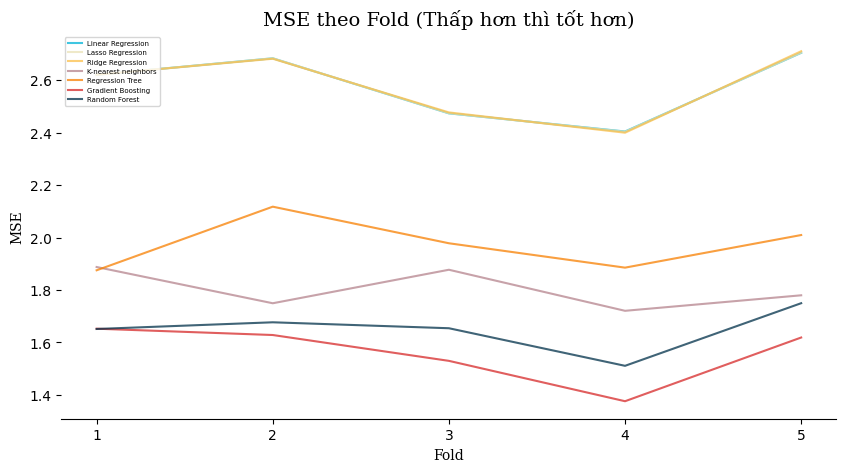

In [84]:
x = np.arange(1, 6, step=1)
labels = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'K-nearest neighbors', 'Regression Tree', 'Gradient Boosting', 'Random Forest']
colors = ["#00b4d8", "#eae2b7", "#fcbf49", '#b5838d', "#f77f00", "#d62828", "#003049"]

fig, ax = plt.subplots(figsize=(10, 5))
for i, label in enumerate(labels):
    ax.plot(x, -extracted_scores['neg_mean_squared_error'][i], label=label, color=colors[i], linewidth=1.5, alpha = 0.75)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(1, 6, step=1))
ax.set_xlabel("Fold", family = 'serif')
ax.yaxis.set_ticks_position("left")
ax.set_ylabel("MSE", family = 'serif')

ax.legend(loc = "upper left",fontsize="5")
plt.title("MSE theo Fold (Thấp hơn thì tốt hơn)",  family = 'serif', fontsize = 14)
plt.show()

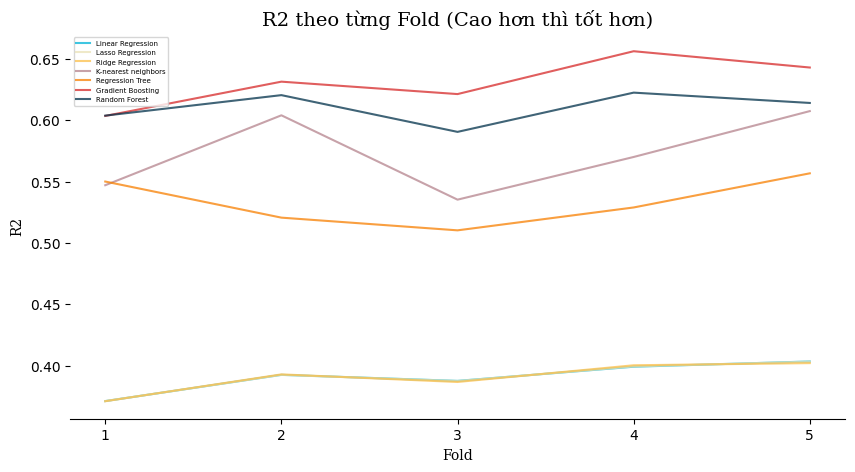

In [85]:
x = np.arange(1, 6, step=1)
labels = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'K-nearest neighbors', 'Regression Tree', 'Gradient Boosting', 'Random Forest']
colors = ["#00b4d8", "#eae2b7", "#fcbf49", '#b5838d', "#f77f00", "#d62828", "#003049"]

fig, ax = plt.subplots(figsize=(10, 5))
for i, label in enumerate(labels):
    ax.plot(x, extracted_scores['r2'][i], label=label, color=colors[i], linewidth=1.5, alpha = 0.75)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(1, 6, step=1))
ax.set_xlabel("Fold", family = 'serif')
ax.yaxis.set_ticks_position("left")
ax.set_ylabel("R2", family = 'serif')

ax.legend(loc = "upper left",fontsize="5")
plt.title("R2 theo từng Fold (Cao hơn thì tốt hơn)", family = 'serif', fontsize = 14)
plt.show()

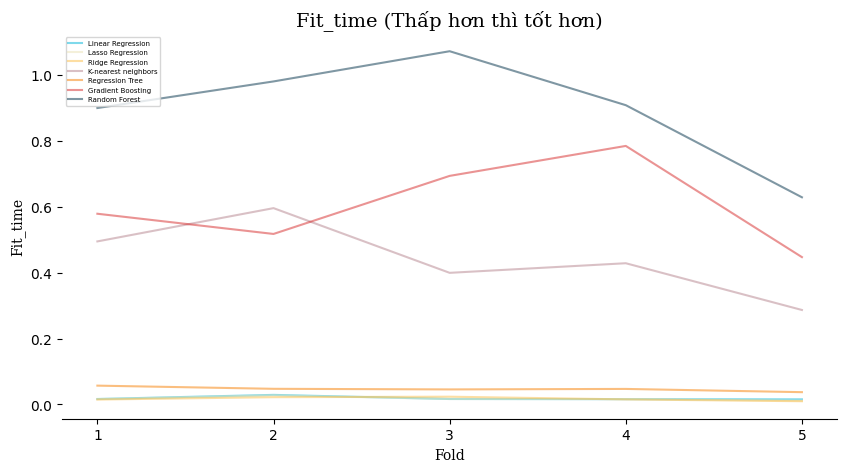

In [86]:
x = np.arange(1, 6, step=1)
labels = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'K-nearest neighbors', 'Regression Tree', 'Gradient Boosting', 'Random Forest']
colors = ["#00b4d8", "#eae2b7", "#fcbf49", '#b5838d', "#f77f00", "#d62828", "#003049"]

fig, ax = plt.subplots(figsize=(10, 5))
for i, label in enumerate(labels):
    ax.plot(x, extracted_scores['fit_time'][i], label=label, color=colors[i], linewidth=1.5, alpha = 0.5)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(1, 6, step=1))
ax.set_xlabel("Fold", family = 'serif')
ax.yaxis.set_ticks_position("left")
ax.set_ylabel("Fit_time", family = 'serif')

ax.legend(loc = "upper left",fontsize="5")
plt.title("Fit_time (Thấp hơn thì tốt hơn)",  family = 'serif', fontsize = 14)
plt.show()

## **c) Đánh giá**

Mỗi mô hình có cách xử lý dữ liệu khác nhau. Nhằm thuận tiện cho quá trình so sánh, các mô hình được khái quát hóa thành một pipeline bao gồm tất cả các quá trình từ dữ liệu thô ban đầu đến kết quả thu được. \
Sử dụng cross-validation; các tham số đánh giá MSE, R2; ta thu được mô hình Gradient Boosting (sử dụng thư viện HistGradientBoostingRegressor) mang lại kết quả tốt nhất. Khi xét trên thời gian chạy. Những mô hình hồi quy đơn giản như Linear Regression, Ridge Regression, Lasso Regression mang lại thời gian thực thi nhanh hơn so với các mô hình còn lại. Điểm mạnh của mô hình GradientBoosting (HistGradientBoostingRegressor) có thời gian chạy tốt  hơn hẳn so với các mô hình dựa trên cây khác